In [14]:
library(xts)
library(PerformanceAnalytics)
library(tidyquant)

ERROR: Error in library(tidyquant): there is no package called ‘tidyquant’


In [15]:
install.packages('tidyquant', repos='http://cran.us.r-project.org',
                 '/Users/justinsimcock/miniconda3/envs/dawp/lib/R/library/')

also installing the dependencies ‘ps’, ‘processx’, ‘xopen’, ‘callr’, ‘fs’, ‘usethis’, ‘git2r’, ‘pkgbuild’, ‘pkgload’, ‘rcmdcheck’, ‘roxygen2’, ‘RcppArmadillo’, ‘reprex’, ‘devtools’, ‘forecast’, ‘tidyverse’, ‘timetk’

Warning message in install.packages("tidyquant", repos = "http://cran.us.r-project.org", :
“installation of package ‘ps’ had non-zero exit status”Warning message in install.packages("tidyquant", repos = "http://cran.us.r-project.org", :
“installation of package ‘fs’ had non-zero exit status”Warning message in install.packages("tidyquant", repos = "http://cran.us.r-project.org", :
“installation of package ‘git2r’ had non-zero exit status”Warning message in install.packages("tidyquant", repos = "http://cran.us.r-project.org", :
“installation of package ‘RcppArmadillo’ had non-zero exit status”Warning message in install.packages("tidyquant", repos = "http://cran.us.r-project.org", :
“installation of package ‘processx’ had non-zero exit status”Warning message in install.packag

In [3]:
DATA_FOLDER <- '~/Resilio Sync/FXBootcamp/'

In [2]:
prices_from_resilio <- function(filename, date_format="%Y%m%d") {
  prices = read.table(paste0(DATA_FOLDER, '/RiskPremia', '/', filename, '.csv'), header=TRUE, sep=",", row.names="Date") 
  #rownames(prices) = as.Date(rownames(prices), format = date_format)
  prices <- as.xts(prices, order.by = as.Date(rownames(prices), format = date_format))
  
  # calculate returns
  returns <- Return.calculate(prices$Close)
  #returns = (prices$Close - stats::lag(prices$Close)) / abs(stats::lag(prices$Close))
  # this is equivalent to returns <- exp(diff(log(prices$Close))) - 1
  
  prices$Cum_Return = rep(1, length(prices$Close))
  prices$Cum_Return[-1] = cumprod(1+returns[-1])
  
  return(prices)
}

In [9]:
# US Equity price series generated from VFINX mutual fund prices
EQ_US_df <- prices_from_resilio('VFINX')
EQ_US <- EQ_US_df$Cum_Return

# US Bond total return index generated from VBMFX mutual fund prices
BOND_US_df <- prices_from_resilio('VBMFX')
BOND_US <- BOND_US_df$Cum_Return

# make extended gold data
source(paste0(DATA_FOLDER, '/Code/risk-premia/gold_processing.R'))

# Gold total return index generated by extending GSCI Gold index back with Gold spot prices
GOLD_df <- read.table(paste0(DATA_FOLDER, '/RiskPremia/extended_GCSI.csv'), header=TRUE, sep=",")
GOLD <- as.xts(GOLD_df$Cum_Ret, order.by = as.Date(GOLD_df[,1]))

# Treasury bill returns from VFISX mutual fund prices
TBILL_US_df <- prices_from_resilio('VFISX')
TBILL_US <- TBILL_US_df$Cum_Return

# Merge data for plotting
# GOLD series has observations on days the mututal funds did not trade and vice versa.
# We decide to deal with this by  left joining the gold series to the combined equity and bond series
# and carrying forward any NAs in the GOLD series.
indexes <- na.omit(na.locf(merge(merge(EQ_US, BOND_US, TBILL_US), GOLD, join = 'left')))
colnames(indexes) <- c('EQ_US','BOND_US', 'TBILL_US', 'GOLD')

# Calculate daily, weekly and monthly discrete returns
returns_daily <- na.omit(Return.calculate(indexes, method = 'discrete'))
returns_monthly <- na.omit(Return.calculate(indexes[endpoints(indexes, on='months')], method = 'discrete'))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:xts’:

    first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



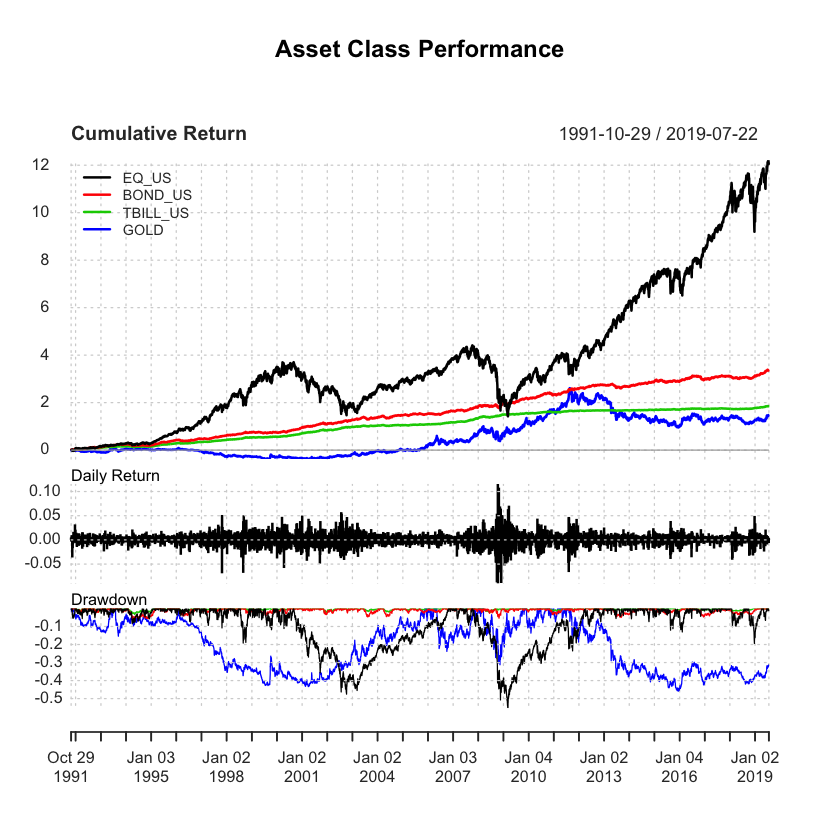

In [14]:
charts.PerformanceSummary(returns_daily, main = 'Asset Class Performance')

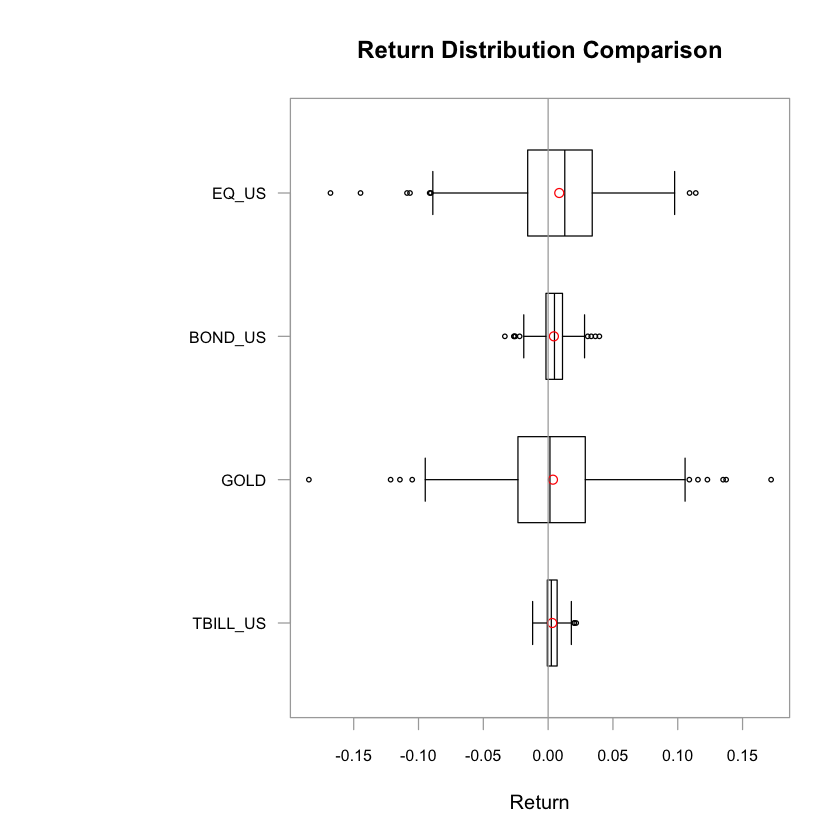

In [15]:
chart.Boxplot(returns_monthly)

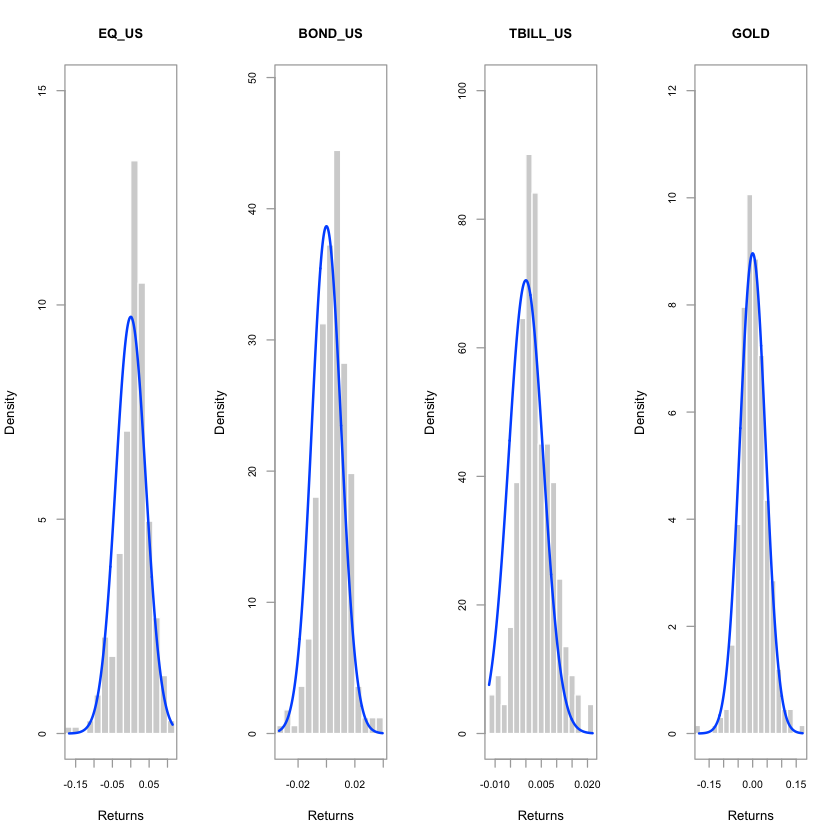

In [16]:
par(mfrow=c(1,4))
chart.Histogram(returns_monthly[,1], methods = 'add.centered')
chart.Histogram(returns_monthly[,2], methods = 'add.centered')
chart.Histogram(returns_monthly[,3], methods = 'add.centered')
chart.Histogram(returns_monthly[,4], methods = 'add.centered')

In [17]:
table.AnnualizedReturns(returns_monthly)

,EQ_US,BOND_US,TBILL_US,GOLD
Annualized Return,0.0968,0.0540,0.0383,0.0333
Annualized Std Dev,0.1422,0.0357,0.0196,0.1542
Annualized Sharpe (Rf=0%),0.6809,1.5120,1.9536,0.2161


In [18]:
table.DownsideRisk(returns_monthly)

,EQ_US,BOND_US,TBILL_US,GOLD
Semi Deviation,0.0312,0.0074,0.0037,0.0303
Gain Deviation,0.0238,0.0070,0.0045,0.0315
Loss Deviation,0.0303,0.0064,0.0029,0.0264
Downside Deviation (MAR=10%),0.0311,0.0097,0.0074,0.0329
Downside Deviation (Rf=0%),0.0272,0.0053,0.0022,0.0283
Downside Deviation (0%),0.0272,0.0053,0.0022,0.0283
Maximum Drawdown,0.5097,0.0499,0.0241,0.4352
Historical VaR (95%),-0.0656,-0.0112,-0.0048,-0.0613
Historical ES (95%),-0.0922,-0.0187,-0.0082,-0.0860
Modified VaR (95%),-0.0648,-0.0128,-0.0055,-0.0658


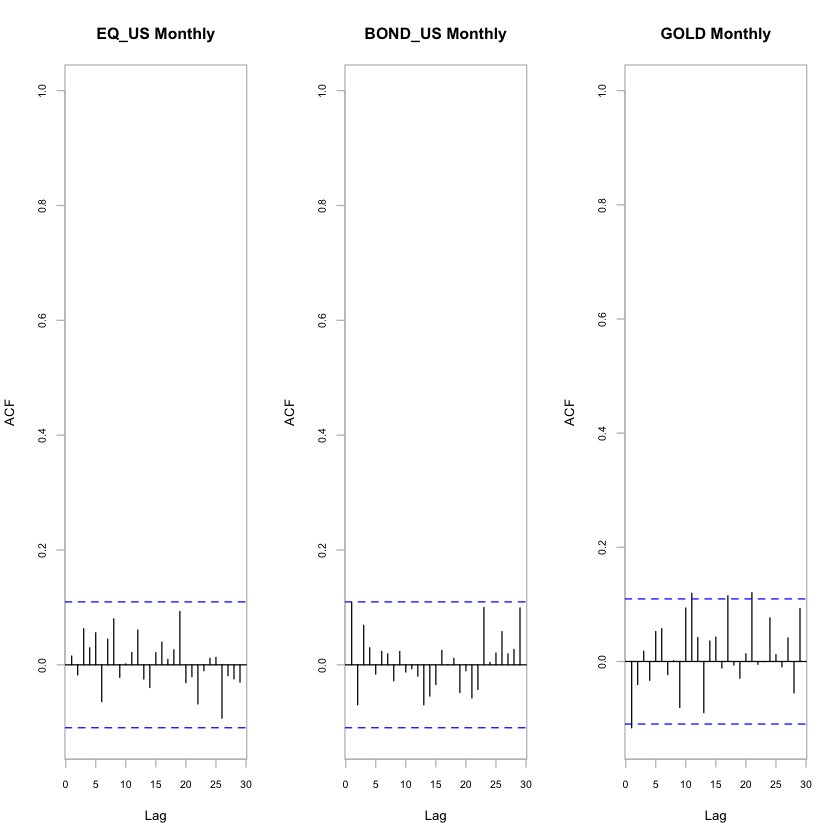

In [19]:
par(mfrow=c(1,3))
chart.ACF(returns_monthly$EQ_US, main=c('EQ_US Monthly'))
chart.ACF(returns_monthly$BOND_US, main=c('BOND_US Monthly'))
chart.ACF(returns_monthly$GOLD, main=c('GOLD Monthly'))

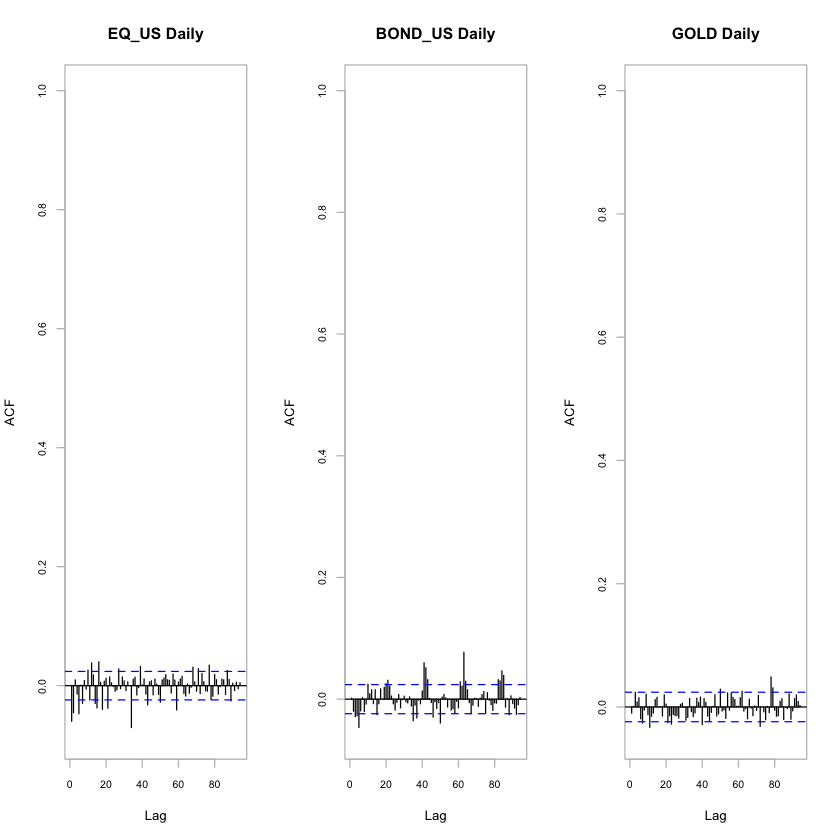

In [20]:
par(mfrow=c(1,3))
chart.ACF(returns_daily$EQ_US, main=c('EQ_US Daily'))
chart.ACF(returns_daily$BOND_US, main=c('BOND_US Daily'))
chart.ACF(returns_daily$GOLD, main=c('GOLD Daily'))

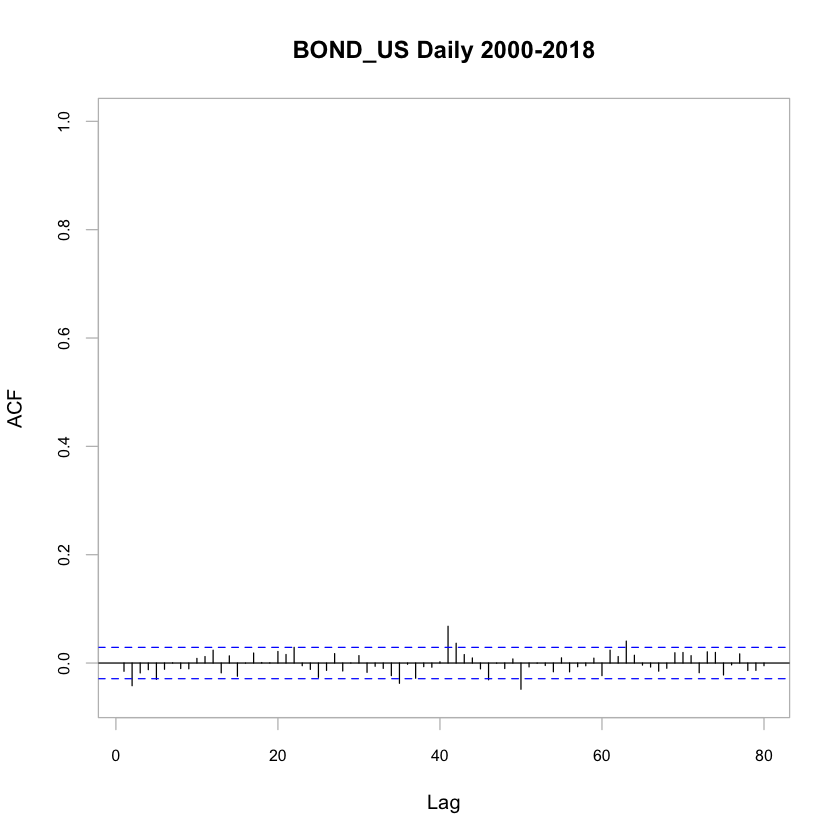

In [36]:
chart.ACF(returns_daily["2000-01-01/2019-01-01"]$BOND_US, main=c('BOND_US Daily 2000-2018'))

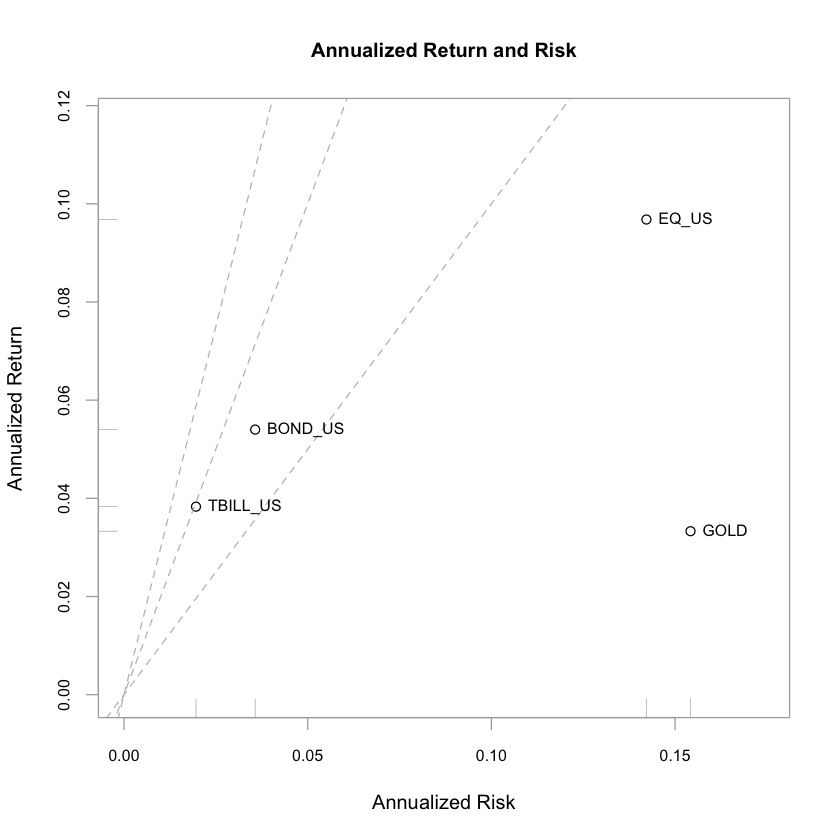

In [37]:
chart.RiskReturnScatter(returns_monthly)


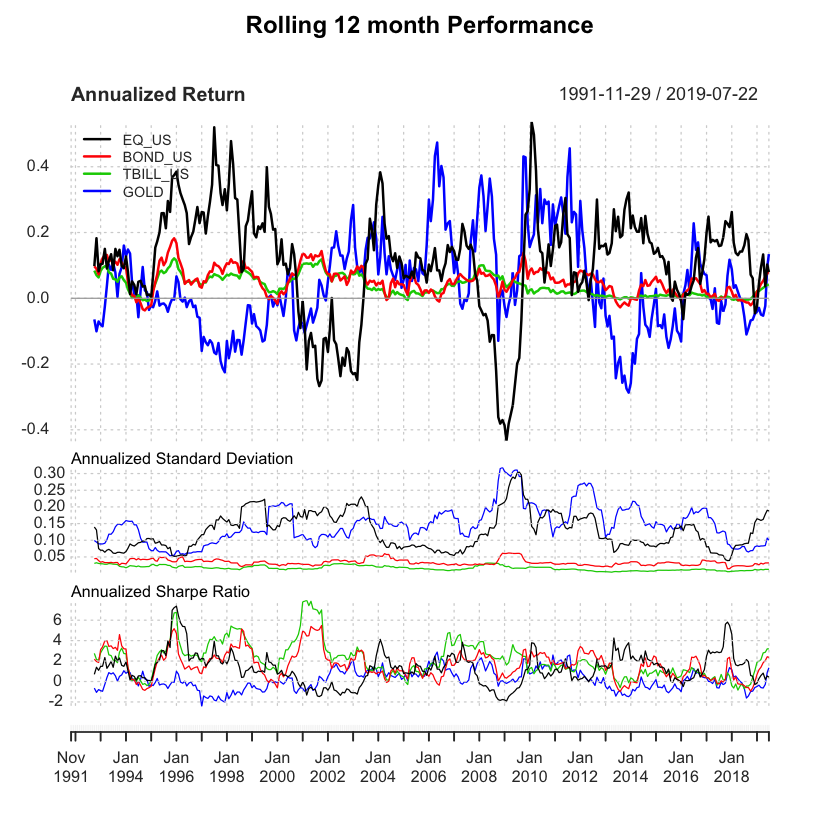

In [38]:
charts.RollingPerformance(returns_monthly, width = 12, legend.loc = 'topleft')


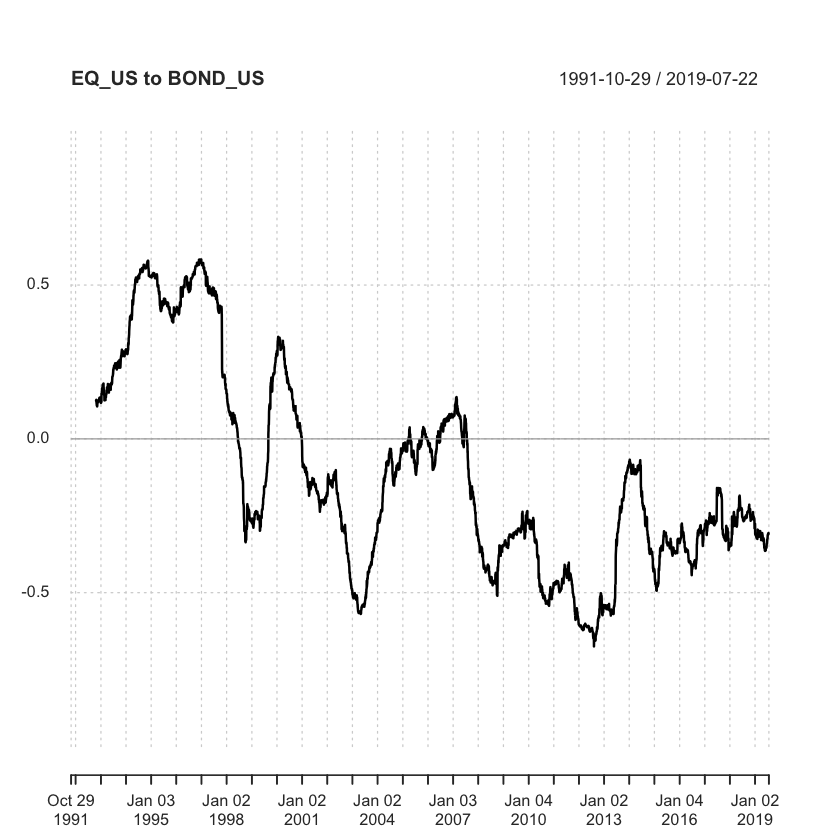

In [39]:
chart.RollingCorrelation(returns_daily[,1], returns_daily[,2], width = 252)


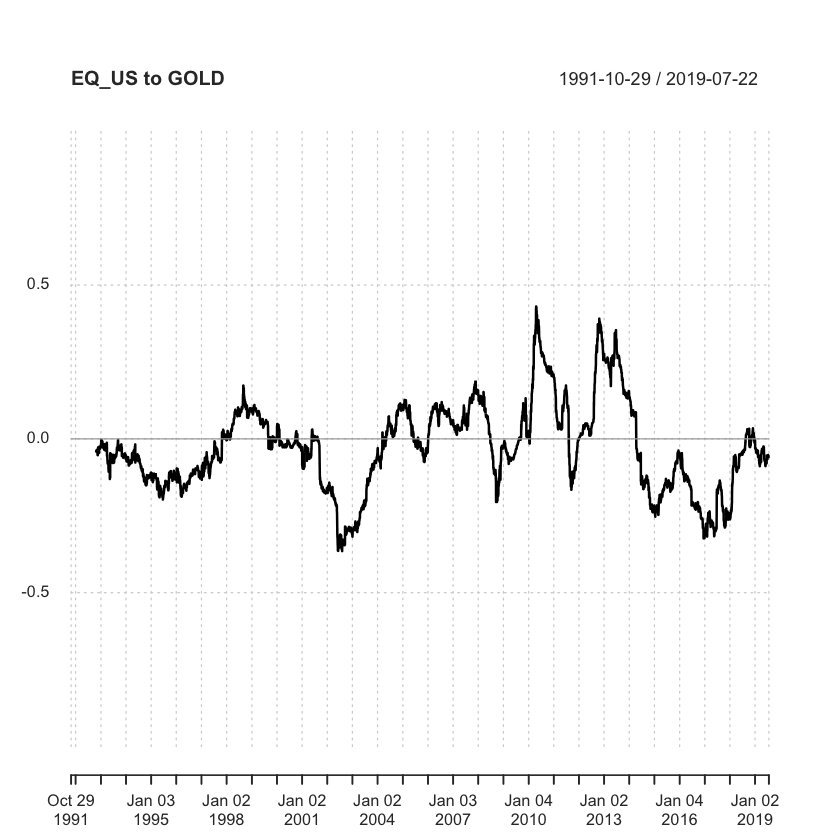

In [40]:
chart.RollingCorrelation(returns_daily[,1], returns_daily[,4], width = 252)


In [41]:
EW_portfolio <- Return.portfolio(returns_monthly, weights = c(0.25,0.25,0.25,0.25), rebalance_on = 'months')
EW_compare <- merge(EW_portfolio, returns_monthly[,'EQ_US'], join='left')
table.AnnualizedReturns(EW_compare)

,portfolio.returns,EQ_US
Annualized Return,0.0597,0.0968
Annualized Std Dev,0.0559,0.1422
Annualized Sharpe (Rf=0%),1.0688,0.6809


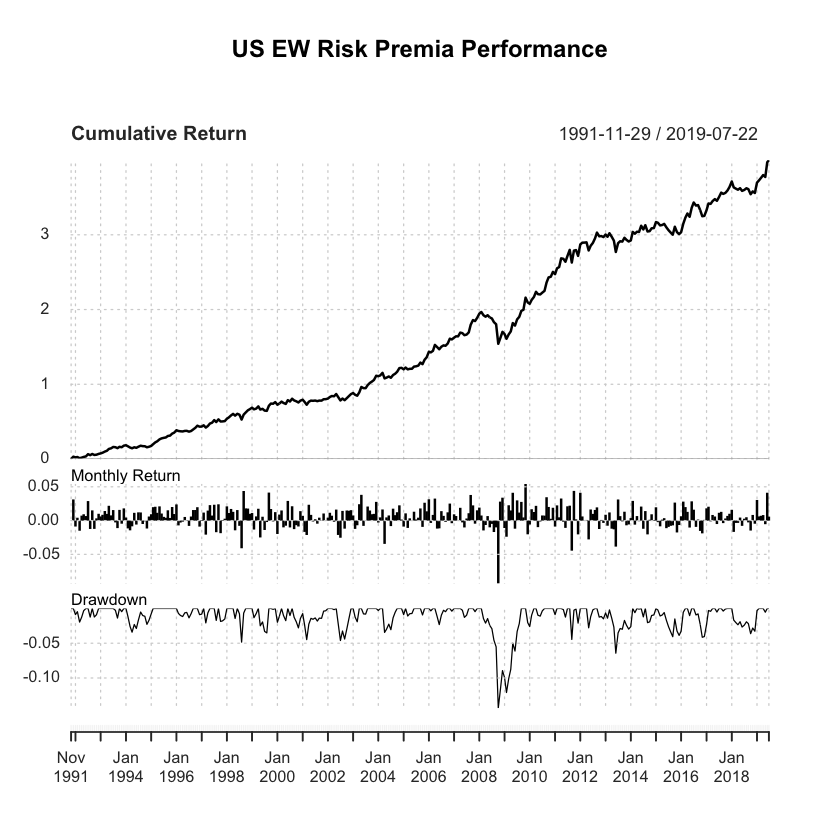

In [42]:
charts.PerformanceSummary(EW_portfolio, main = 'US EW Risk Premia Performance')


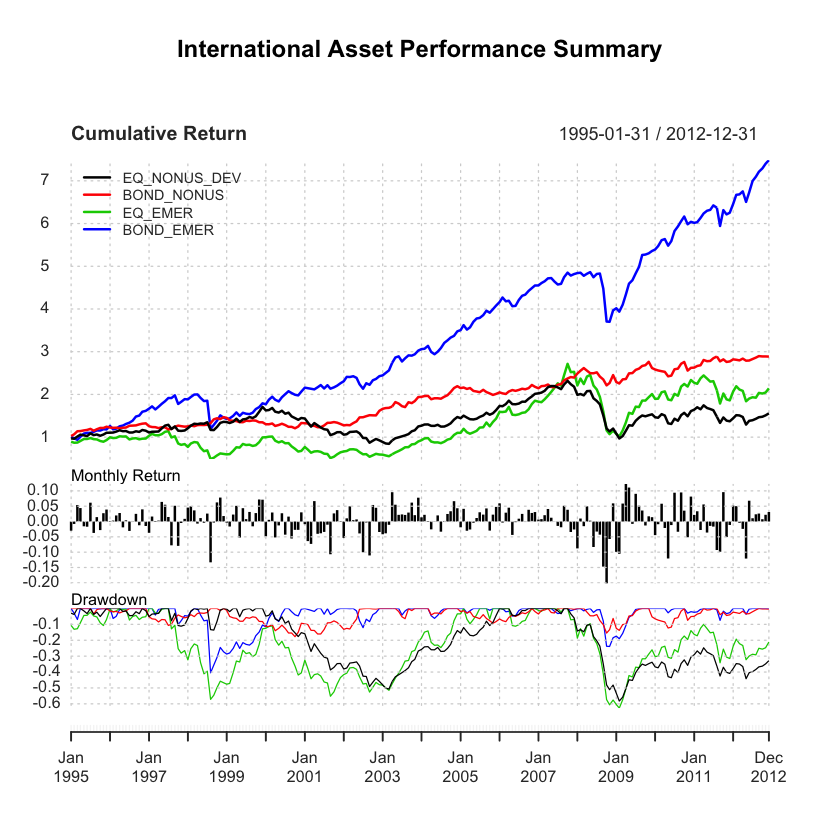

In [43]:
# Non-US Developed Markets Equity total return index generated from XMSC MSCI index prices
EQ_NONUS_DEV_df <- prices_from_resilio('XMSC-F') 
EQ_NONUS_DEV <- EQ_NONUS_DEV_df$Cum_Return

# Emerging Markets Equity total return index generated from MXEA MSCI index prices
EQ_EMER_df <- prices_from_resilio('MXEA-F')  
EQ_EMER <- EQ_EMER_df$Cum_Return

# International Bonds total return index generated from Benham International Bond Fund prices
BOND_NONUS_df <- prices_from_resilio('BEGBX')
BOND_NONUS <- BOND_NONUS_df$Cum_Return

# Emerging Markets Bond total return index generated from T Rowe Price Emerging Markets Bond Fund
BOND_EMER_df <- prices_from_resilio('PREMX') 
BOND_EMER <- BOND_EMER_df$Cum_Return

# Merge data for plotting
nonus_index <- na.omit(na.locf(merge(EQ_NONUS_DEV, BOND_NONUS, EQ_EMER, BOND_EMER)))
colnames(nonus_index) <- c('EQ_NONUS_DEV', 'BOND_NONUS', 'EQ_EMER', 'BOND_EMER')

# Keep data from 2013 aside. (Note it's not a very good OOS period, as we know what happened!)
nonus_sample <- nonus_index['::2012']

# Calculate daily, weekly and monthly discrete returns
nonus_returns_monthly <- na.omit(Return.calculate(nonus_sample[endpoints(nonus_sample, on='months')], method = 'discrete'))

charts.PerformanceSummary(nonus_returns_monthly, wealth.index = TRUE, legend.loc = 'topleft'
                          , main = 'International Asset Performance Summary')

In [44]:
nonus_EW_portfolio <- Return.portfolio(nonus_returns_monthly, weights = c(0.25,0.25,0.25,0.25), rebalance_on = 'months')
table.AnnualizedReturns(nonus_EW_portfolio)

,portfolio.returns
Annualized Return,0.0678
Annualized Std Dev,0.1332
Annualized Sharpe (Rf=0%),0.5091


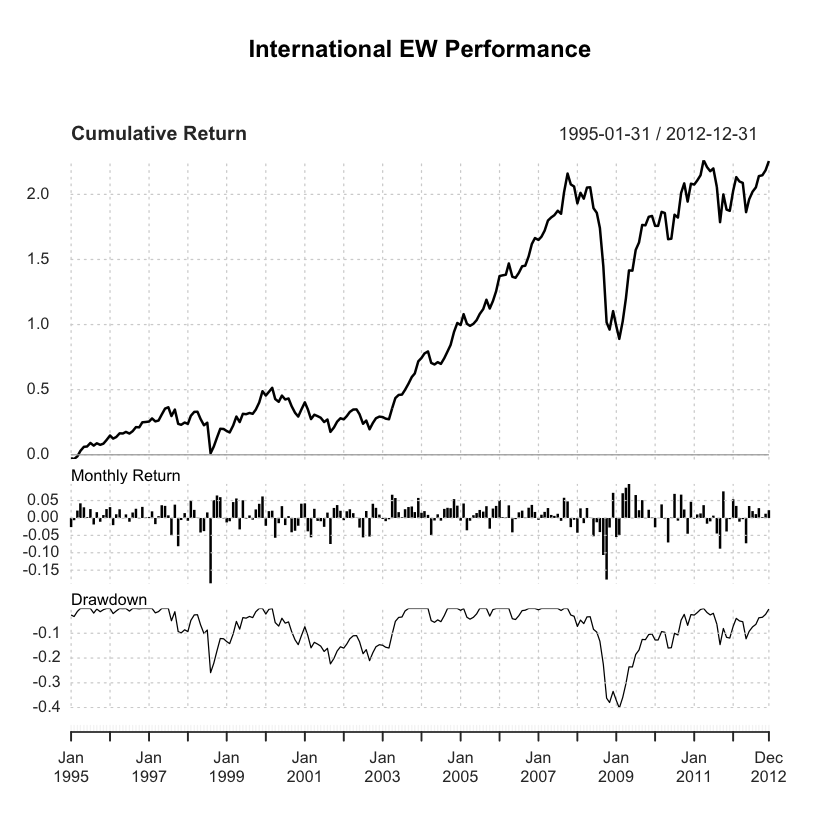

In [45]:
charts.PerformanceSummary(nonus_EW_portfolio, main = 'International EW Performance')
